In [5]:
!nvidia-smi

Thu Aug 24 06:21:26 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    23W / 300W |      0MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
!pip install -U -qq gdown kaggle

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
!mkdir -p ~/.kaggle/ && cp /content/drive/MyDrive/all_AI_code/kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c hackathon-online-realfakenumbers

 56% 1.00M/1.79M [00:00<00:00, 2.21MB/s]
100% 1.79M/1.79M [00:00<00:00, 3.60MB/s]


In [4]:
!unzip -q /content/hackathon-online-realfakenumbers.zip

In [6]:
import zipfile
import os
import os
from glob import glob
import pandas as pd
import numpy as np

In [7]:
with zipfile.ZipFile("./hackathon-online-realfakenumbers.zip", "r") as zip_ref:
    print("Unzipping main_zip data...")
    zip_ref.extractall('./data/')

os.remove("./hackathon-online-realfakenumbers.zip")

Unzipping main_zip data...


In [8]:
def walk_through_dir(dir_path):
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"'{dirpath}' There are {len(dirnames)} directories and {len(filenames)} flie(s).")

walk_through_dir('./data/')

'./data/' There are 2 directories and 1 flie(s).
'./data/test_set-20230712T063018Z-001' There are 1 directories and 0 flie(s).
'./data/test_set-20230712T063018Z-001/test_set' There are 1 directories and 0 flie(s).
'./data/test_set-20230712T063018Z-001/test_set/test' There are 0 directories and 1010 flie(s).
'./data/Train_1000' There are 1 directories and 0 flie(s).
'./data/Train_1000/Train_1000รูป' There are 2 directories and 0 flie(s).
'./data/Train_1000/Train_1000รูป/0' There are 0 directories and 487 flie(s).
'./data/Train_1000/Train_1000รูป/1' There are 0 directories and 514 flie(s).


In [9]:
image_path = glob('./data/Train_1000/Train_1000รูป/*/*')
print(len(image_path))
df_train = pd.DataFrame({"path":image_path})
df_train['label'] = df_train['path'].map(lambda x : x.split("/")[-2])

df_train['fold'] =-1
fold = 0
for i in range(len(df_train)):
    if i!=0 :
            fold += 1
    if fold ==10 :
        fold =0
    df_train.loc[i,'fold'] = fold
#random shuffle
df_train=df_train.sample(frac=1)
df_train

df_train.sample(3)

1001


,path,label,fold
723,./data/Train_1000/Train_1000รูป/1/R_ (42).jpg,1,3
535,./data/Train_1000/Train_1000รูป/1/R_ (7).png,1,5
192,./data/Train_1000/Train_1000รูป/0/F_ (23).jpg,0,2


In [10]:
BASE_DIR = "./data/test_set-20230712T063018Z-001/test_set/test/"
df_test = pd.read_csv('./data/sample_submission.csv')
df_test['path'] = BASE_DIR + df_test['img_name']
df_test_learn = df_test['path']
print(len(df_test))
df_test.sample(3)

1010


,img_name,code,path
364,new_name_364.png,NaN,./data/test_set-20230712T063018Z-001/test_set/...
716,new_name_716.png,NaN,./data/test_set-20230712T063018Z-001/test_set/...
843,new_name_843.png,NaN,./data/test_set-20230712T063018Z-001/test_set/...


In [11]:
!pip -q install git+https://github.com/rwightman/pytorch-image-models.git
!pip -q install GPUtil

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 18.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [12]:
import GPUtil
GPUtil.showUtilization()

def free_gpu_cache():
    print("Initial GPU Usage")
    GPUtil.showUtilization()
    torch.cuda.empty_cache()
    print("GPU Usage after emptying the cache")
    GPUtil.showUtilization()

| ID | GPU | MEM |
------------------
|  0 |  0% |  0% |


In [13]:
from fastai.vision.all import *

import albumentations

from tqdm.notebook import tqdm, trange
from PIL import Image, ImageChops, ImageEnhance

import cv2

In [20]:
!mkdir save_models

In [15]:
image_size = 448
batch = 8
model_name =  "eva02_base_patch14_448.mim_in22k_ft_in22k_in1k"

In [16]:
def convert_to_ela_image(image, quality=90):
    temp_filename = f'/content/image_test/temp_file_{image[0].sum()}.jpg'
    ela_filename = f'/content/image_test/temp_ela{image[0].sum()}.png'
    image = Image.fromarray(image)
    image=image.resize((image_size,image_size))
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)

    ela_image = ImageChops.difference(image, temp_image)

    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff

    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)

    return (np.array(ela_image))

In [17]:
class AlbumentationsTransform (RandTransform):
    split_idx,order=None,2
    def __init__(self, train_aug, valid_aug): store_attr()

    def before_call(self, b, split_idx):
        self.idx = split_idx

    def encodes(self, img: PILImage):
        if self.idx == 0:
            aug_img = self.train_aug(image=np.array(img))['image']
        else:
            aug_img = self.valid_aug(image=np.array(img))['image']
        return PILImage.create(aug_img)

In [18]:
def get_train_aug():
  return albumentations.Compose([
            albumentations.Resize(always_apply=False, p=1.0, height=image_size, width=image_size, interpolation=cv2.INTER_CUBIC),
            albumentations.Rotate(limit=(-25, 25)),
            albumentations.HorizontalFlip(p=0.5),
            albumentations.VerticalFlip(p=0.5),
            albumentations.ShiftScaleRotate(always_apply=False, p=1.0, shift_limit_x=(-0.06, 0.06), shift_limit_y=(-0.06, 0.06), scale_limit=(-0.09999999999999998, 0.10000000000000009), rotate_limit=(-25, 25), interpolation=0, border_mode=0, value=(255, 255, 255), mask_value=None, rotate_method='largest_box'),
    ], p=1.)

def get_valid_aug():
  return albumentations.Compose([
            albumentations.Resize(always_apply=False, p=1.0, height=image_size, width=image_size, interpolation=cv2.INTER_CUBIC),
    ], p=1.0)

item_tfms = AlbumentationsTransform(get_train_aug(), get_valid_aug())
batch_tfms = [Normalize.from_stats(*imagenet_stats)]

In [19]:
def get_data(fold=0):
    return DataBlock(
        blocks = (ImageBlock,CategoryBlock),
        get_x = ColReader(0),
        get_y = ColReader(1),
        splitter = IndexSplitter(df_train[df_train['fold'] == fold].index),
        item_tfms = item_tfms,
        batch_tfms = batch_tfms
      ).dataloaders(df_train, bs=batch)

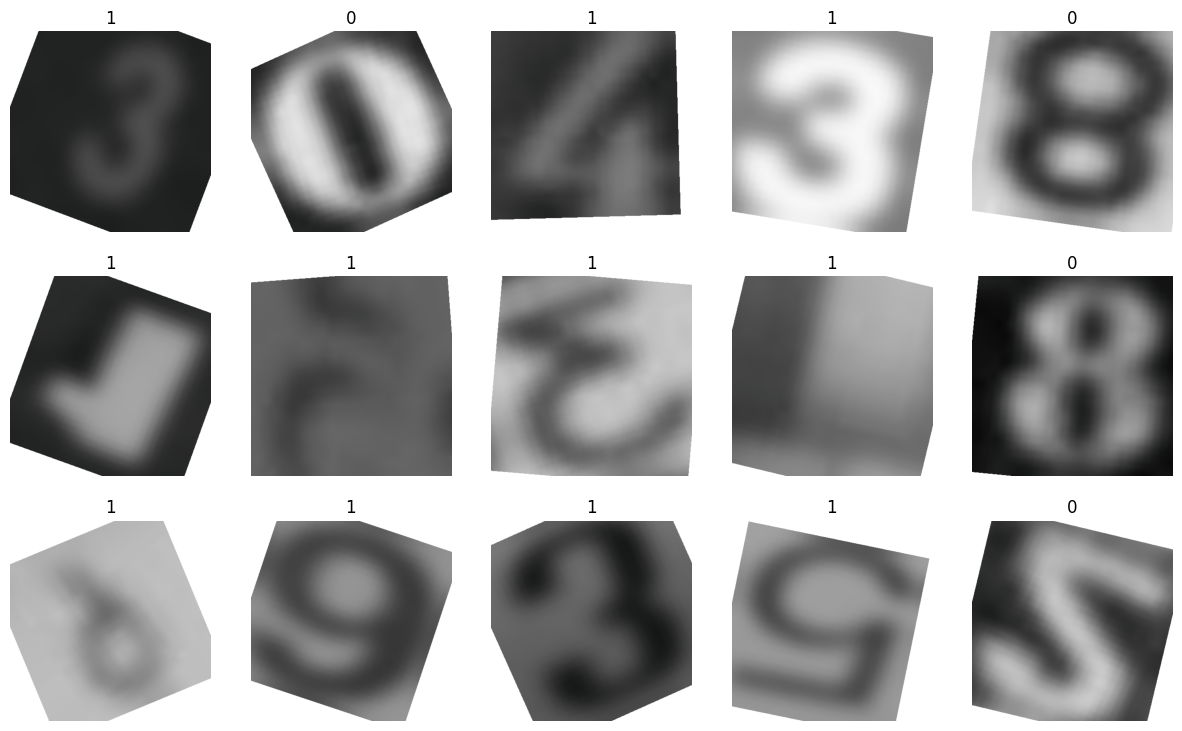

In [38]:
dls = get_data()
dls.train.show_batch(max_n=30)

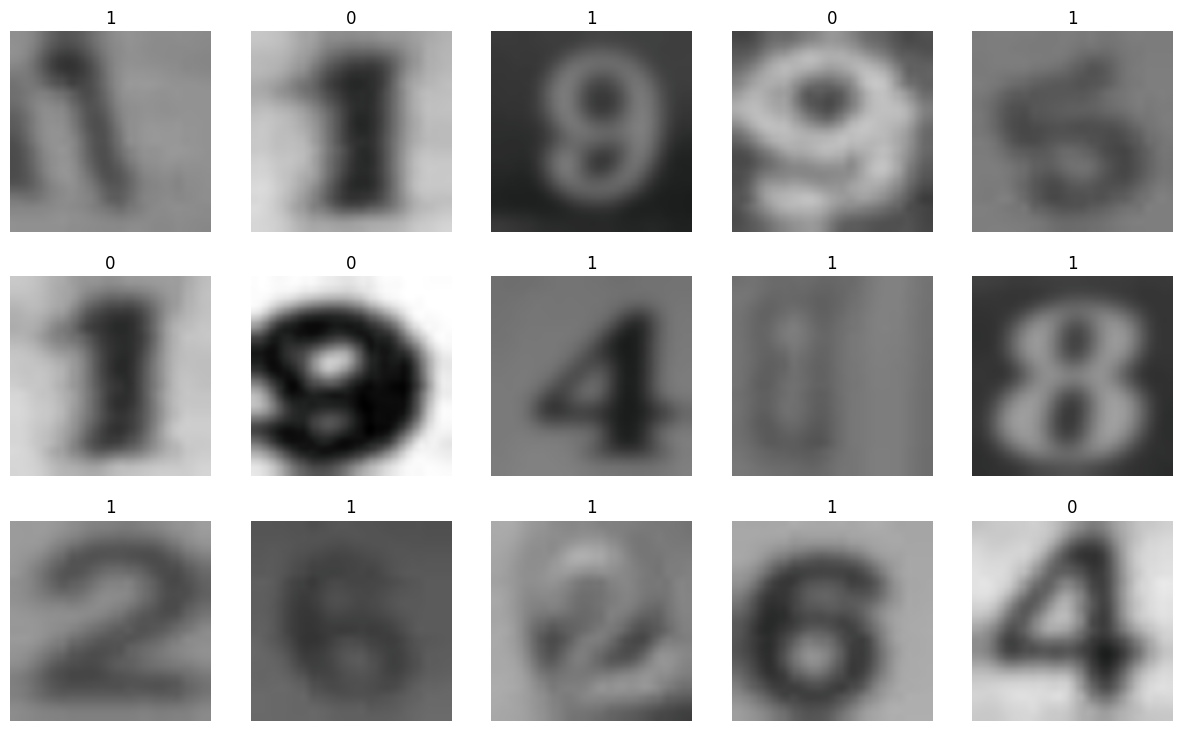

In [39]:
dls.valid.show_batch(max_n=30)

fold1000:   0%|          | 0/10 [00:00<?, ?it/s]

-----------------------
fold 0
-----------------------


/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


epoch,train_loss,valid_loss,f1_score,time
0,0.760966,2.152465,0.504740,00:32


Better model found at epoch 0 with valid_loss value: 2.1524648666381836.


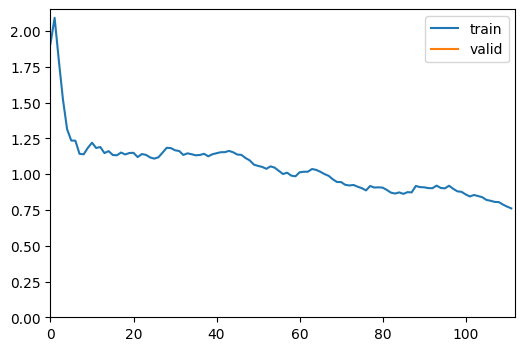

epoch,train_loss,valid_loss,f1_score,time
0,0.500541,0.531955,0.801494,00:31
1,0.354568,0.241636,0.891046,00:30
2,0.214203,0.289138,0.900903,00:29
3,0.262985,0.286233,0.900747,00:29
4,0.193962,0.465648,0.871287,00:29
5,0.146722,0.062480,0.979960,00:29
6,0.161121,0.100219,0.970003,00:29
7,0.180380,0.135293,0.960079,00:33


Better model found at epoch 0 with valid_loss value: 0.5319549441337585.


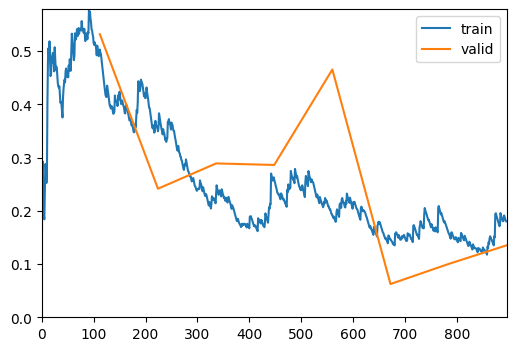

Better model found at epoch 1 with valid_loss value: 0.24163611233234406.
Better model found at epoch 5 with valid_loss value: 0.062480468302965164.


/usr/local/lib/python3.10/dist-packages/fastai/learner.py:59: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


[0.06243126094341278, 0.9799603174603175]


Initial GPU Usage
| ID | GPU | MEM |
------------------
|  0 | 44% | 48% |
GPU Usage after emptying the cache
| ID | GPU | MEM |
------------------
|  0 | 44% | 25% |
-----------------------
fold 1
-----------------------


epoch,train_loss,valid_loss,f1_score,time
0,0.758857,0.998283,0.724109,00:26


Better model found at epoch 0 with valid_loss value: 0.9982826709747314.


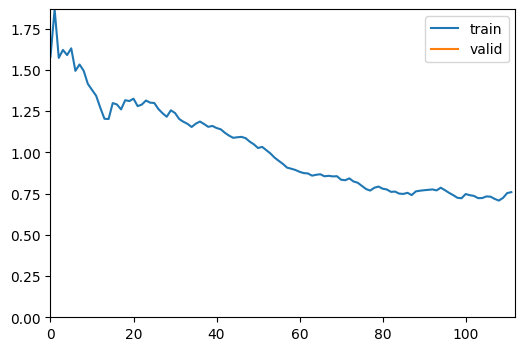

epoch,train_loss,valid_loss,f1_score,time
0,0.436170,0.474086,0.889102,00:29
1,0.315901,0.574864,0.876847,00:31
2,0.348543,0.266703,0.929143,00:29
3,0.225140,0.299512,0.939123,00:29
4,0.143694,0.237022,0.949388,00:29
5,0.147471,0.165676,0.949388,00:29
6,0.102402,0.149805,0.959596,00:29
7,0.084224,0.126644,0.969755,00:29


Better model found at epoch 0 with valid_loss value: 0.47408562898635864.


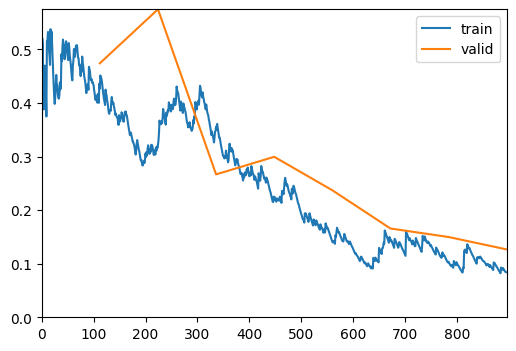

Better model found at epoch 2 with valid_loss value: 0.2667030096054077.
Better model found at epoch 4 with valid_loss value: 0.23702220618724823.
Better model found at epoch 5 with valid_loss value: 0.16567592322826385.
Better model found at epoch 6 with valid_loss value: 0.14980505406856537.
Better model found at epoch 7 with valid_loss value: 0.1266438513994217.


/usr/local/lib/python3.10/dist-packages/fastai/learner.py:59: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


[0.1266666203737259, 0.9697550156265753]


Initial GPU Usage
| ID | GPU | MEM |
------------------
|  0 | 52% | 56% |
GPU Usage after emptying the cache
| ID | GPU | MEM |
------------------
|  0 | 52% | 26% |
-----------------------
fold 2
-----------------------


epoch,train_loss,valid_loss,f1_score,time
0,0.610981,0.851368,0.768122,00:26


Better model found at epoch 0 with valid_loss value: 0.8513683080673218.


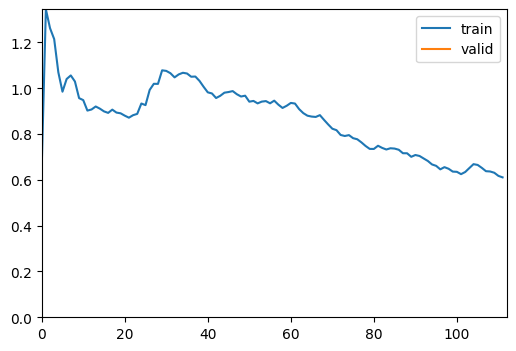

epoch,train_loss,valid_loss,f1_score,time
0,0.522163,0.424683,0.809524,00:29
1,0.372006,0.281694,0.879952,00:29
2,0.336176,0.059961,0.959596,00:29
3,0.325846,0.068556,0.969309,00:29
4,0.173211,0.067469,0.969633,00:29
5,0.119825,0.176414,0.959596,00:29
6,0.083736,0.144970,0.959596,00:30
7,0.107773,0.065063,0.969633,00:29


Better model found at epoch 0 with valid_loss value: 0.42468297481536865.


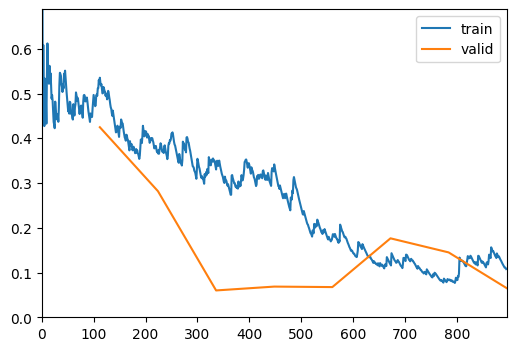

Better model found at epoch 1 with valid_loss value: 0.28169432282447815.
Better model found at epoch 2 with valid_loss value: 0.059961166232824326.


/usr/local/lib/python3.10/dist-packages/fastai/learner.py:59: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


[0.06000525876879692, 0.9595959595959596]


Initial GPU Usage
| ID | GPU | MEM |
------------------
|  0 | 86% | 56% |
GPU Usage after emptying the cache
| ID | GPU | MEM |
------------------
|  0 | 27% | 37% |
-----------------------
fold 3
-----------------------


epoch,train_loss,valid_loss,f1_score,time
0,0.725294,1.559348,0.642857,00:26


Better model found at epoch 0 with valid_loss value: 1.5593475103378296.


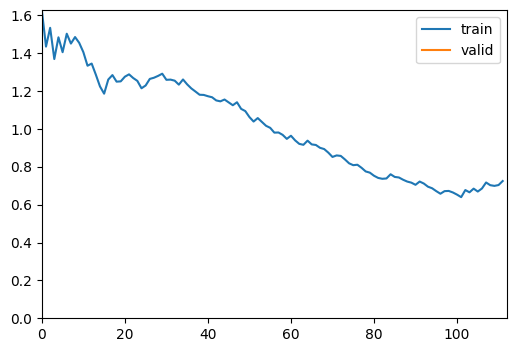

epoch,train_loss,valid_loss,f1_score,time
0,0.283657,0.658098,0.789800,00:29
1,0.378779,0.704124,0.737892,00:29
2,0.324389,0.275108,0.916667,00:29
3,0.250174,0.357979,0.894914,00:30
4,0.220788,0.145623,0.958949,00:30
5,0.227714,0.170670,0.948512,00:30
6,0.190332,0.214283,0.937991,00:29
7,0.104878,0.185657,0.937991,00:30


Better model found at epoch 0 with valid_loss value: 0.6580982804298401.


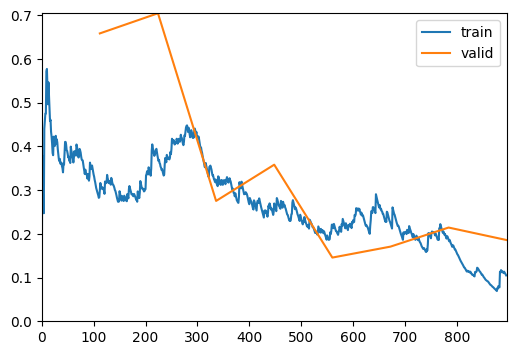

Better model found at epoch 2 with valid_loss value: 0.27510756254196167.
Better model found at epoch 4 with valid_loss value: 0.1456225961446762.


/usr/local/lib/python3.10/dist-packages/fastai/learner.py:59: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


[0.14557614922523499, 0.9589490968801313]


Initial GPU Usage
| ID | GPU | MEM |
------------------
|  0 | 53% | 64% |
GPU Usage after emptying the cache
| ID | GPU | MEM |
------------------
|  0 | 53% | 47% |
-----------------------
fold 4
-----------------------


epoch,train_loss,valid_loss,f1_score,time
0,0.651588,1.947308,0.565732,00:26


Better model found at epoch 0 with valid_loss value: 1.9473083019256592.


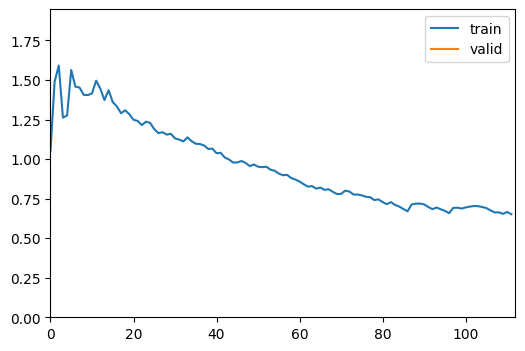

epoch,train_loss,valid_loss,f1_score,time
0,0.545556,0.700040,0.742871,00:30
1,0.351143,0.165890,0.917321,00:30
2,0.237951,0.133441,0.948512,00:30
3,0.189679,0.107723,0.958333,00:30
4,0.168024,0.170439,0.958333,00:30
5,0.157165,0.016070,0.989702,00:29
6,0.232548,0.065450,0.979330,00:29
7,0.140807,0.023829,0.989702,00:30


Better model found at epoch 0 with valid_loss value: 0.7000402808189392.


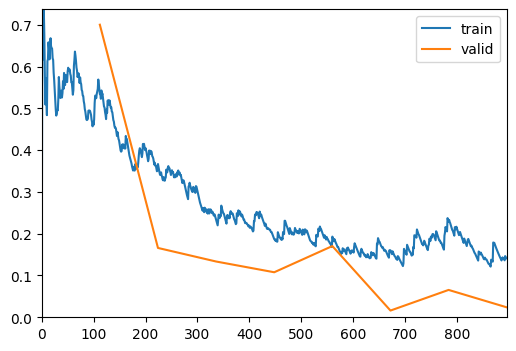

Better model found at epoch 1 with valid_loss value: 0.16588985919952393.
Better model found at epoch 2 with valid_loss value: 0.13344112038612366.
Better model found at epoch 3 with valid_loss value: 0.1077226996421814.
Better model found at epoch 5 with valid_loss value: 0.016069596633315086.


/usr/local/lib/python3.10/dist-packages/fastai/learner.py:59: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


[0.016109418123960495, 0.9897023993409535]


Initial GPU Usage
| ID | GPU | MEM |
------------------
|  0 |  0% | 59% |
GPU Usage after emptying the cache
| ID | GPU | MEM |
------------------
|  0 | 81% | 21% |
-----------------------
fold 5
-----------------------


epoch,train_loss,valid_loss,f1_score,time
0,0.764501,0.717563,0.794745,00:26


Better model found at epoch 0 with valid_loss value: 0.7175627946853638.


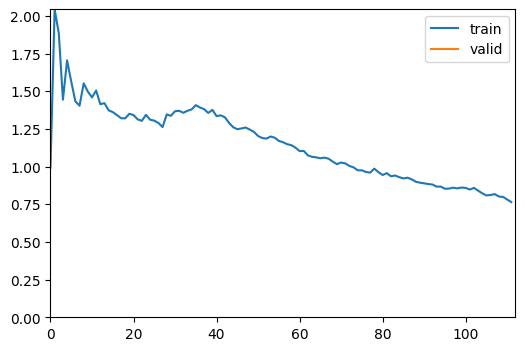

epoch,train_loss,valid_loss,f1_score,time
0,0.401385,1.031908,0.726776,00:30
1,0.412981,1.920267,0.612789,00:29
2,0.338690,0.747880,0.794745,00:29
3,0.231163,0.216482,0.919872,00:29
4,0.200183,0.025346,0.989975,00:29
5,0.179028,0.081356,0.960000,00:29
6,0.120132,0.024184,0.979992,00:30
7,0.090118,0.017363,1.000000,00:30


Better model found at epoch 0 with valid_loss value: 1.031908392906189.


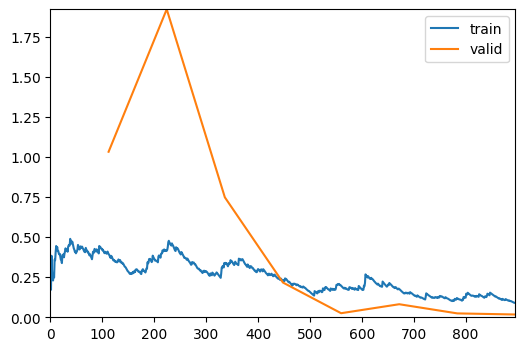

Better model found at epoch 2 with valid_loss value: 0.7478800415992737.
Better model found at epoch 3 with valid_loss value: 0.21648237109184265.
Better model found at epoch 4 with valid_loss value: 0.0253456998616457.
Better model found at epoch 6 with valid_loss value: 0.0241839736700058.
Better model found at epoch 7 with valid_loss value: 0.01736297458410263.


/usr/local/lib/python3.10/dist-packages/fastai/learner.py:59: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


[0.017363080754876137, 1.0]


Initial GPU Usage
| ID | GPU | MEM |
------------------
|  0 | 83% | 56% |
GPU Usage after emptying the cache
| ID | GPU | MEM |
------------------
|  0 | 19% | 34% |
-----------------------
fold 6
-----------------------


epoch,train_loss,valid_loss,f1_score,time
0,0.633326,3.846824,0.340436,00:26


Better model found at epoch 0 with valid_loss value: 3.8468239307403564.


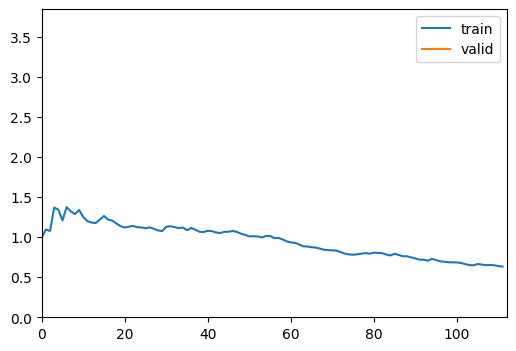

epoch,train_loss,valid_loss,f1_score,time
0,0.426200,1.305854,0.669333,00:29
1,0.454697,0.556666,0.796002,00:29
2,0.357583,0.079561,0.979871,00:29
3,0.379171,0.044771,0.979968,00:30
4,0.282459,0.262197,0.879566,00:30
5,0.116530,0.030292,1.000000,00:31
6,0.086897,0.034383,0.989975,00:30
7,0.126817,0.021869,0.989975,00:31


Better model found at epoch 0 with valid_loss value: 1.3058538436889648.


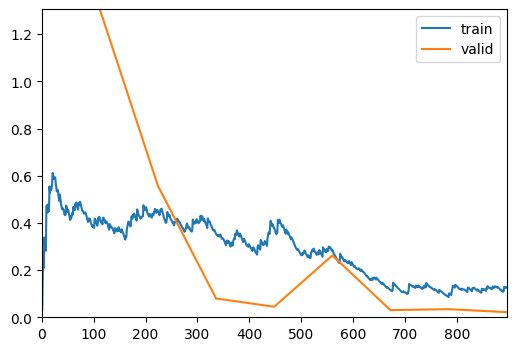

Better model found at epoch 1 with valid_loss value: 0.5566656589508057.
Better model found at epoch 2 with valid_loss value: 0.07956148684024811.
Better model found at epoch 3 with valid_loss value: 0.044771477580070496.
Better model found at epoch 5 with valid_loss value: 0.03029191493988037.
Better model found at epoch 7 with valid_loss value: 0.02186930738389492.


/usr/local/lib/python3.10/dist-packages/fastai/learner.py:59: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


[0.021850474178791046, 0.9899749373433584]


Initial GPU Usage
| ID | GPU | MEM |
------------------
|  0 | 13% | 64% |
GPU Usage after emptying the cache
| ID | GPU | MEM |
------------------
|  0 | 63% | 26% |
-----------------------
fold 7
-----------------------


epoch,train_loss,valid_loss,f1_score,time
0,0.718138,2.013476,0.547716,00:26


Better model found at epoch 0 with valid_loss value: 2.0134758949279785.


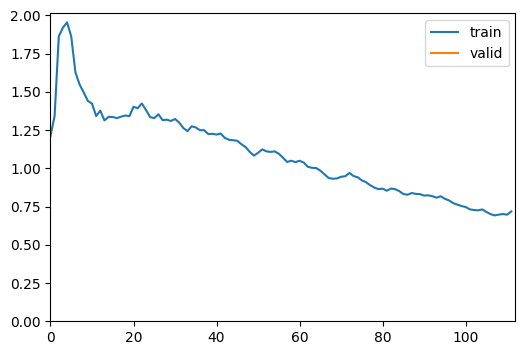

epoch,train_loss,valid_loss,f1_score,time
0,0.417343,0.718927,0.817370,00:29
1,0.379009,0.206545,0.929993,00:29
2,0.280831,1.113305,0.729167,00:30
3,0.285888,0.360062,0.909919,00:30
4,0.189798,0.132253,0.949995,00:30
5,0.138024,0.425941,0.919968,00:30
6,0.141526,0.544665,0.889724,00:30
7,0.144064,0.373670,0.919968,00:29


Better model found at epoch 0 with valid_loss value: 0.7189268469810486.


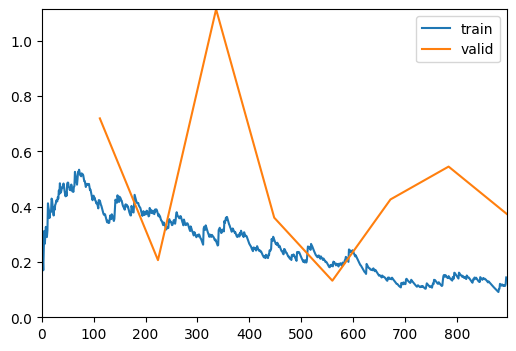

Better model found at epoch 1 with valid_loss value: 0.20654457807540894.
Better model found at epoch 4 with valid_loss value: 0.1322527825832367.


/usr/local/lib/python3.10/dist-packages/fastai/learner.py:59: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


[0.13226599991321564, 0.9499949994999499]


Initial GPU Usage
| ID | GPU | MEM |
------------------
|  0 | 86% | 56% |
GPU Usage after emptying the cache
| ID | GPU | MEM |
------------------
|  0 | 17% | 37% |
-----------------------
fold 8
-----------------------


epoch,train_loss,valid_loss,f1_score,time
0,0.640822,1.721441,0.563419,00:26


Better model found at epoch 0 with valid_loss value: 1.7214407920837402.


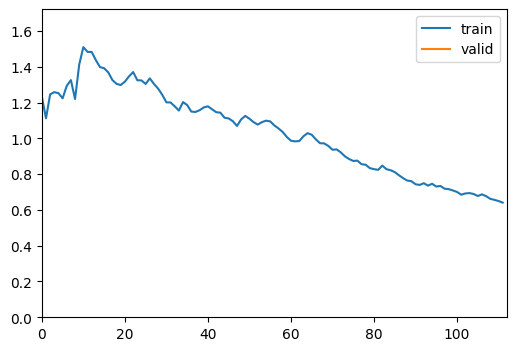

epoch,train_loss,valid_loss,f1_score,time
0,0.410491,0.573250,0.815271,00:29
1,0.392619,0.116507,0.979992,00:30
2,0.269812,0.099181,0.960000,00:30
3,0.270819,0.221220,0.939904,00:29
4,0.266178,0.126851,0.959984,00:30
5,0.162612,0.168990,0.959984,00:30
6,0.164463,0.121351,0.969997,00:30
7,0.101817,0.086369,0.980000,00:30


Better model found at epoch 0 with valid_loss value: 0.573250412940979.


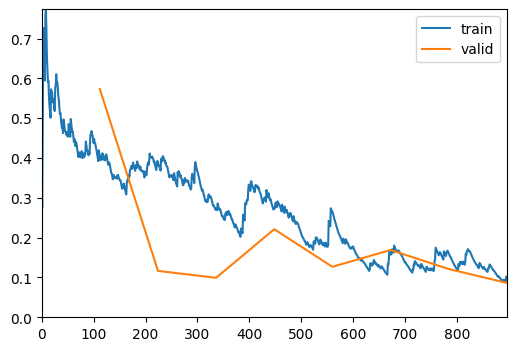

Better model found at epoch 1 with valid_loss value: 0.11650685220956802.
Better model found at epoch 2 with valid_loss value: 0.09918120503425598.
Better model found at epoch 7 with valid_loss value: 0.08636884391307831.


/usr/local/lib/python3.10/dist-packages/fastai/learner.py:59: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


[0.08636114746332169, 0.98]


Initial GPU Usage
| ID | GPU | MEM |
------------------
|  0 | 77% | 64% |
GPU Usage after emptying the cache
| ID | GPU | MEM |
------------------
|  0 | 25% | 47% |
-----------------------
fold 9
-----------------------


epoch,train_loss,valid_loss,f1_score,time
0,0.540787,1.354509,0.660179,00:27


Better model found at epoch 0 with valid_loss value: 1.3545089960098267.


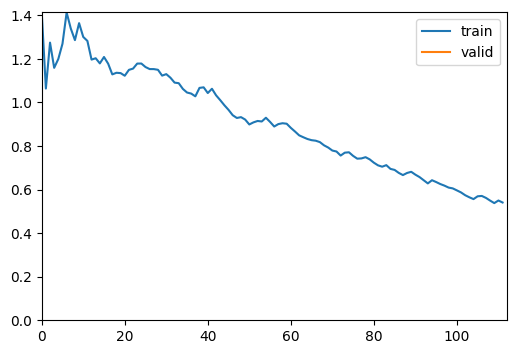

epoch,train_loss,valid_loss,f1_score,time
0,0.358234,0.668677,0.789474,00:29
1,0.347308,0.489547,0.849985,00:30
2,0.367686,1.346693,0.694002,00:30
3,0.273087,0.372950,0.869883,00:30
4,0.159368,0.053469,0.969309,00:30
5,0.141104,0.019500,0.989770,00:30
6,0.193401,0.060081,0.979600,00:30
7,0.124770,0.031050,0.979600,00:30


Better model found at epoch 0 with valid_loss value: 0.6686765551567078.


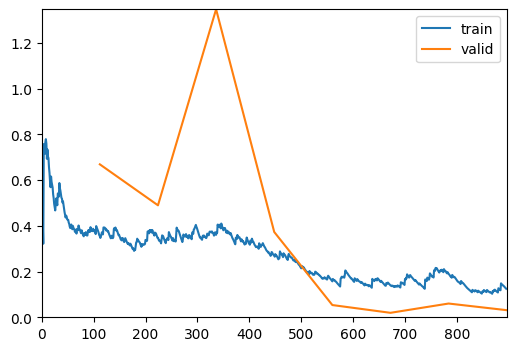

Better model found at epoch 1 with valid_loss value: 0.4895473122596741.
Better model found at epoch 3 with valid_loss value: 0.37295013666152954.
Better model found at epoch 4 with valid_loss value: 0.05346905067563057.
Better model found at epoch 5 with valid_loss value: 0.019499575719237328.


/usr/local/lib/python3.10/dist-packages/fastai/learner.py:59: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


[0.019500788301229477, 0.9897698209718669]


Initial GPU Usage
| ID | GPU | MEM |
------------------
|  0 | 86% | 58% |
GPU Usage after emptying the cache
| ID | GPU | MEM |
------------------
|  0 | 13% | 20% |


In [21]:
all_preds = []
num=10
for i in trange(num,desc=f'fold{i}'):
    print('-----------------------')
    print(f'fold {i}')
    print('-----------------------')
    dls = get_data(i)
    save_cb = SaveModelCallback(monitor='valid_loss',every_epoch=False)
    early_stop_cb = EarlyStoppingCallback(monitor='valid_loss',min_delta=0.001 ,patience=5)
    # Create a list of callbacks
    callbacks = [save_cb,GradientAccumulation(n_acc=32)]  #,WandbCallback(log='all')

    learn = vision_learner(dls, model_name,pretrained=True,
                       path=f'/content/save_models/{i}',
                       cbs=[ShowGraphCallback()] ,  #mixup
                       metrics=[F1Score(average='macro')]).to_fp16()

    learn.fine_tune(8, freeze_epochs=1, cbs=callbacks)

    learn.load('model')
    print(learn.validate())

    tst_dl = learn.dls.test_dl(df_test_learn)
    preds, _ = learn.get_preds(dl=tst_dl)
    all_preds.append(preds)
    if i !=num-1:
        del learn

    free_gpu_cache()

In [22]:
np_reds = np.mean(np.stack(all_preds), axis=0)
np_reds = torch.from_numpy(np_reds)
idxs = np_reds.argmax(dim=1)
vocab = np.array(dls.vocab)

In [23]:
vocab

array(['0', '1'], dtype='<U1')

              precision    recall  f1-score   support

           0       0.98      1.00      0.99        42
           1       1.00      0.98      0.99        58

    accuracy                           0.99       100
   macro avg       0.99      0.99      0.99       100
weighted avg       0.99      0.99      0.99       100



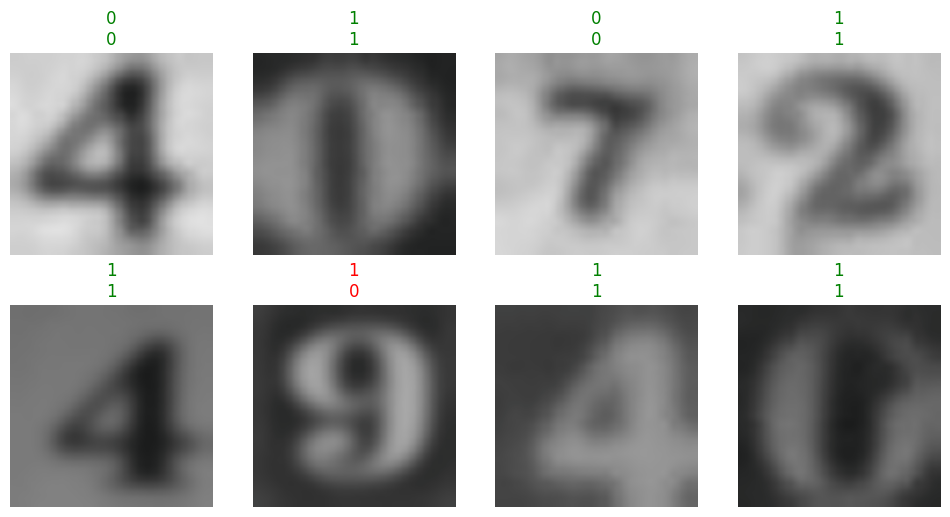

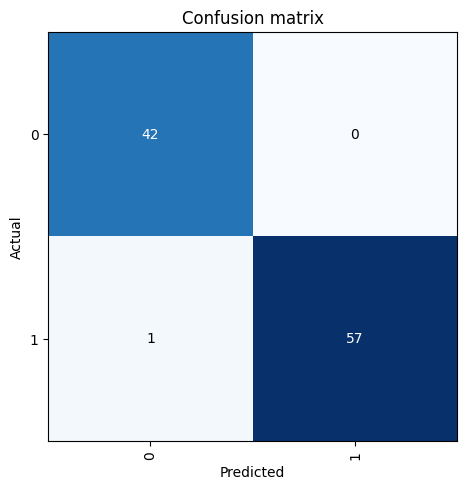

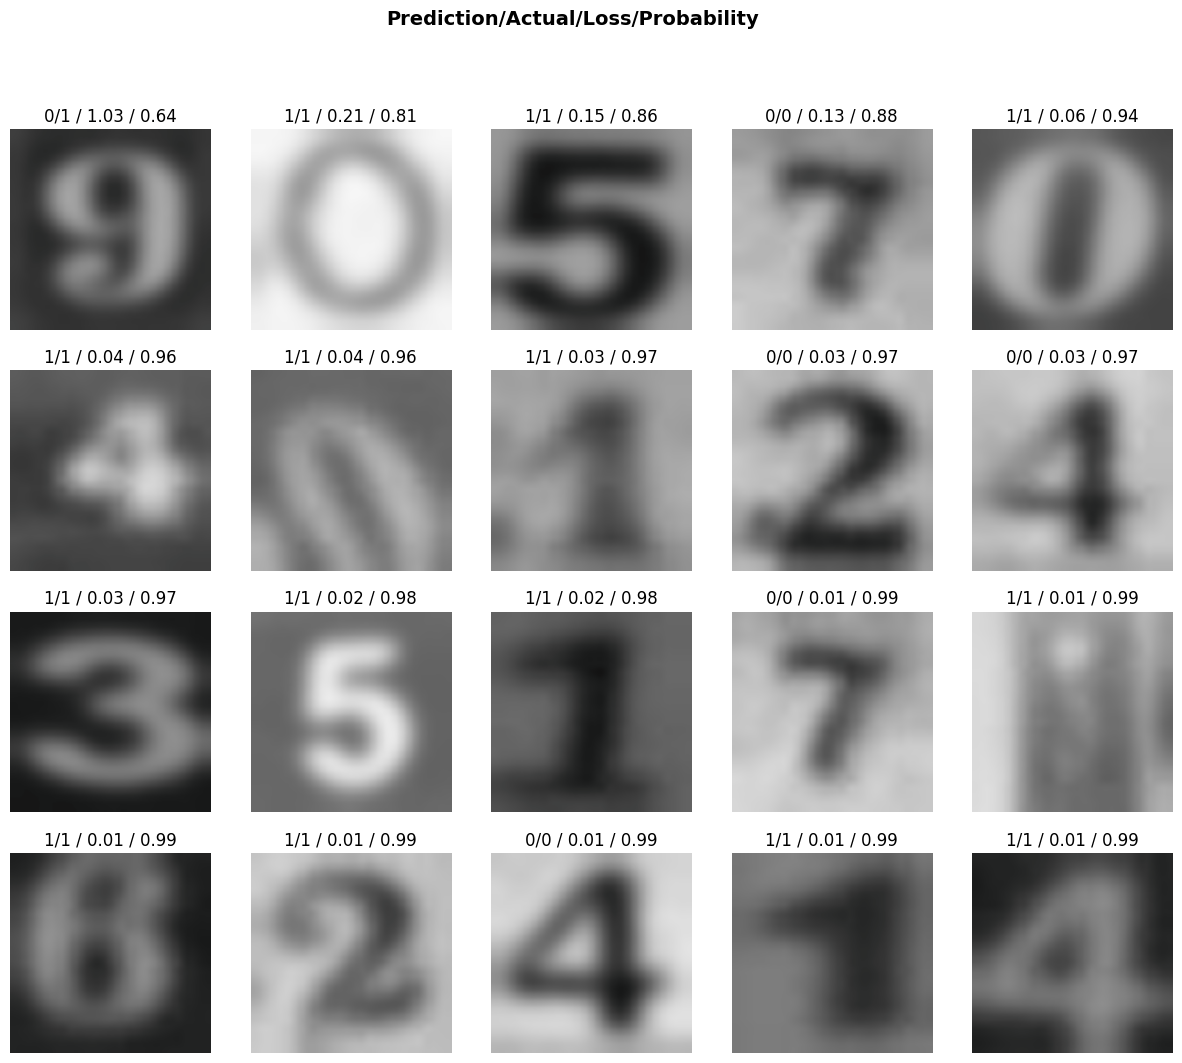

In [25]:
learn.show_results()
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()
interp.print_classification_report()
interp.plot_top_losses(20)

In [26]:
sub = pd.read_csv('/content/sample_submission.csv')
sub.loc[3:,'code'] = vocab[idxs][3:]
sub['code'] =sub['code'].astype('int32')
sub

,img_name,code
0,new_name_0.png,0
1,new_name_1.png,0
2,new_name_2.png,1
3,new_name_3.png,0
4,new_name_4.png,0
...,...,...
1005,new_name_1005.png,0
1006,new_name_1006.png,0
1007,new_name_1007.png,0
1008,new_name_1008.png,0


<Axes: >

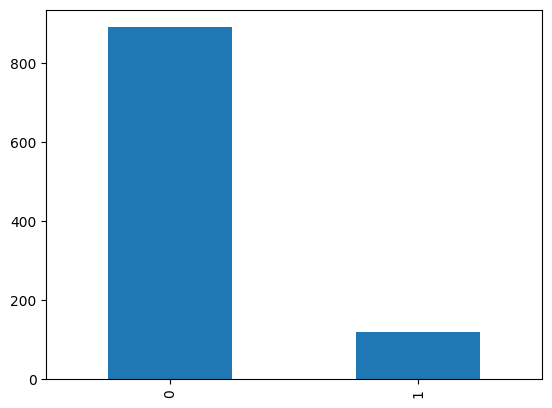

In [27]:
sub['code'].value_counts().plot(kind='bar')

In [56]:
sub.to_csv("submission_base_final.csv",index=False)

In [28]:
sub['prob']=preds.max(dim=1).values.tolist()
sub

,img_name,code,prob
0,new_name_0.png,0,1.000000
1,new_name_1.png,0,1.000000
2,new_name_2.png,1,0.902931
3,new_name_3.png,0,1.000000
4,new_name_4.png,0,0.990732
...,...,...,...
1005,new_name_1005.png,0,0.999999
1006,new_name_1006.png,0,0.874238
1007,new_name_1007.png,0,0.999999
1008,new_name_1008.png,0,1.000000


In [41]:
sub['new'] = -1
for i,column in tqdm(sub.iterrows()):
    if column['prob']< 0.9999:
        sub.loc[i,'new'] = 1
    else :
        sub.loc[i,'new'] = column['code']

0it [00:00, ?it/s]

<Axes: >

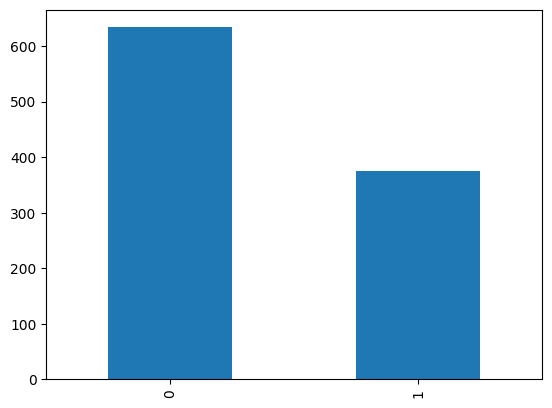

In [42]:
sub['new'].value_counts().plot(kind='bar')

In [43]:
sub_final = pd.read_csv('/content/sample_submission.csv')
sub_final['code'] = sub['new']
sub_final

,img_name,code
0,new_name_0.png,0
1,new_name_1.png,0
2,new_name_2.png,1
3,new_name_3.png,0
4,new_name_4.png,1
...,...,...
1005,new_name_1005.png,0
1006,new_name_1006.png,1
1007,new_name_1007.png,0
1008,new_name_1008.png,0


In [44]:
sub_final.to_csv("submission_prob_9999_final.csv",index=False)